In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time

#from pandas import read_csv, DataFrame, concat

import matplotlib.pyplot as plt
from matplotlib import rc,rcParams

import scipy
from scipy.interpolate import interp1d,LSQUnivariateSpline
from scipy.sparse import csc_matrix
from scipy.optimize import curve_fit,least_squares,minimize
from scipy.stats import median_abs_deviation
from scipy.linalg import svd
from astropy.timeseries import LombScargle

from sys import path as syspath
from sys import argv
import os

import pickle

### Define relevant directories and general parameters for this run

In [2]:
#where to find the data preprocessed by MM-LSD:

star = "Sun"
#star = "Sun_public_oneperday"

indic = "1"

mmlsd_dir = "../MM-LSD"
stardir = f'{mmlsd_dir}/stars/{star}/'
dirdir = f'{mmlsd_dir}/data/{star}/processed/'
resdir = stardir+f"results_{indic}/"


#which pipeline was used to process the data. If not 2.3.5: change vstep. see MM-LSD
pipname = "DRS_2.3.5"
#remove if excllower < flux < exclupper. flux should be between -1 and 0.
excllower = -1.1
exclupper = 0.05

#use a tapas transmittance spectrum to partially correct tellurics (one file is given)
usetapas = True

#step between CCF values in velocity units km/s
vStep = 0.82

#warm-ups of CCD (HARPS-N specific)
wmps = np.array([2457162,2457309,2457479,2457688,2457855,2458072,2458232,2458413,2458555,2458684,2458840,2458998,2459181])


#this is how it is done in MM-LSD.
#inf_name = stardir + 'input.py'
#exec(open(inf_name).read())


stellarrestframe = False
rerun_rvs = False

#c in km/s
ckm = 299792.458

#make some plots
output_intermediate_results = True

In [3]:
syspath.insert(0, f'{mmlsd_dir}/helper_functions/')

from classes import stellar_parameters,analyse,extract_rv_from_common_profiles,Gaussian,runLSD_inv,prep_spec3,RVerror
#from classes import heliocorr,heliocorr2

### Set parameters for computation (velcity grid width etc.)

In [4]:
#fixed as in publication
mindepthparam = 0.2
maxdepthparam = 0.9
modelspecdeviationcut = 0.5
velgridwidth = 2.5
telluric_cut = 0.01

rassoption = 1
erroption = 0
telloption = 1

exclwidelinesparam = 0

### Information about spectra

In [5]:
info_file = pd.read_csv(dirdir+"Info.csv")

#set system RV. i.e. RV that is used to convert absorption line wavelengths from rest frame to stellar frame
systemrv = (info_file["rv_ccf"][0])

In [6]:
rvresults = pd.read_csv(resdir+f"RVs_{indic}.csv")

lsd_norm = rvresults["rv_all_mean"].values
drs_norm = rvresults["rv_ccf"].values
t = rvresults["mjd"].values
t_bjd = info_file["bjd_ccf"]

vzr = rvresults["rv_all_mean"].mean()

#hc,dfwhm,rhk = heliocorr(rt,dirdir)
hc = np.zeros((len(t)))
#hc = np.load("hc_opd.npy")

print("calculate heliocentric correction here if desired")

calculate heliocentric correction here if desired


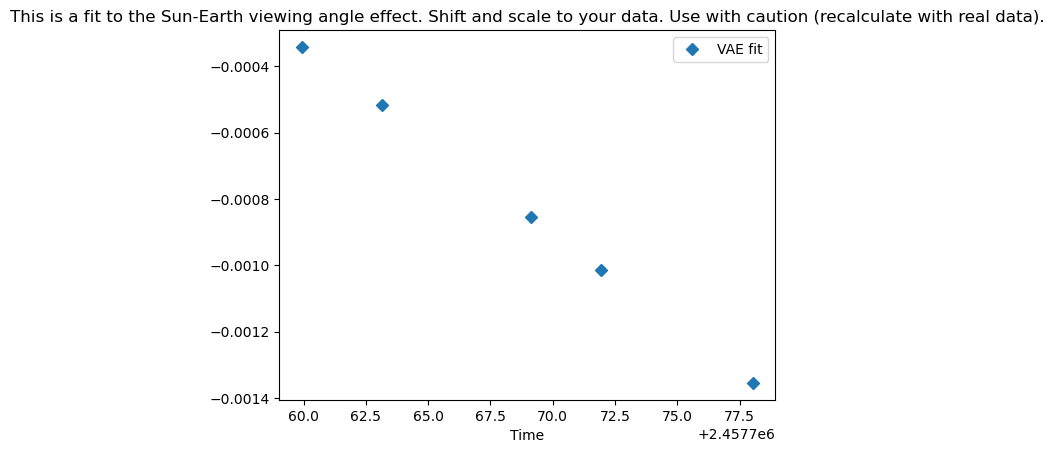

In [7]:
# for the Sun, you need to correct for the CCF shape variation induced by Sun-Earth viewing angle effect (this is not berv).

def vae_fct(t_bjd,a1,b1,c1,a2,b2,c2):
    # BJD used in fit
    return np.sin(t_bjd/a1-c1)*b1+np.sin(t_bjd/a2-c2)*b2

popt_vae = np.array([ 5.80631969e+01,  1.21062364e-03,  1.39556336e+03,  2.90430895e+01,  -1.83973202e-03,  2.76147022e+03])

vae_effect = vae_fct(t_bjd,*popt_vae)

plt.figure()
plt.title("This is a fit to the Sun-Earth viewing angle effect. Shift and scale to your data. Use with caution (recalculate with real data).")
plt.plot(t_bjd,vae_effect,"D",label="VAE fit")
plt.xlabel("Time")
plt.legend()

### Load data from VALD3


In [8]:
valddir = f'{mmlsd_dir}/VALD_files/'
sp = stellar_parameters(star,valddir,dirdir,pipname,ckm)
sp.VALD_data()

loaded ../MM-LSD/VALD_files/Sun.txt


In [9]:
#new
line_mask = np.where((sp.VALDdepths>mindepthparam) & (sp.element!="'CH 1'") & (sp.element!="'CN 1'") & (sp.element!="'MgH 1'") & (sp.element!="'SiH 1'"))

sp.VALDlambdas = sp.VALDlambdas[line_mask]
sp.VALDdepths = sp.VALDdepths[line_mask]
sp.mean_lande = sp.mean_lande[line_mask]
sp.element = sp.element[line_mask]
sp.elow = sp.elow[line_mask]
sp.eup = sp.eup[line_mask]
sp.rad = sp.rad[line_mask]
#sp.jup = sp.jup[line_mask]


### Load data from 1_preprocess notebook


In [10]:
an = analyse(ckm,sp.VALDlambdas,sp.VALDdepths)

In [11]:
with open(dirdir+"data_dict.pkl","rb") as f:
    prov = pickle.load(f)
    
    an.alldata = {}
    
    if rassoption==1:
        an.alldata["spectrum"] = prov["spectrum_overlap_corrected"]
        an.alldata["err"] = prov["err_overlap_corrected"]
        an.alldata["wavelengths"] = prov["wavelengths"]
        
    del prov

In [12]:
# save these for later.

iis = list(an.alldata["spectrum"].keys())

#index numbers of spectra
an.iis = iis

#see input.py
an.excllower = excllower
an.exclupper = exclupper
an.telluric_cut = telluric_cut
an.modelspecdeviationcut = modelspecdeviationcut
an.mindepthparam = mindepthparam
an.maxdepthparam = maxdepthparam
an.exclwidelinesparam = exclwidelinesparam
an.telloption = telloption

nr_of_orders,nr_of_pixels = an.alldata["spectrum"][0].shape

#shift fluxes to between -1 and 0 for lsd procedure
for key in iis:
    an.alldata["spectrum"][key] = an.alldata["spectrum"][key]-1
    
    
    
an.tapas_tellurics = {}
an.resdir = resdir

In [13]:
an.barycentric_to_stellar_restframe = {}
an.observatory_to_barycentric_restframe = {}
an.observatory_to_stellar_restframe = {}

for ii in iis:
    an.barycentric_to_stellar_restframe[ii] = 1.0 / (1.0 + systemrv / ckm)
    an.observatory_to_barycentric_restframe[ii] = 1.0 + info_file["berv"][0] / ckm
    an.observatory_to_stellar_restframe[ii] = (
        an.observatory_to_barycentric_restframe[ii]
        * an.barycentric_to_stellar_restframe[ii]
    )

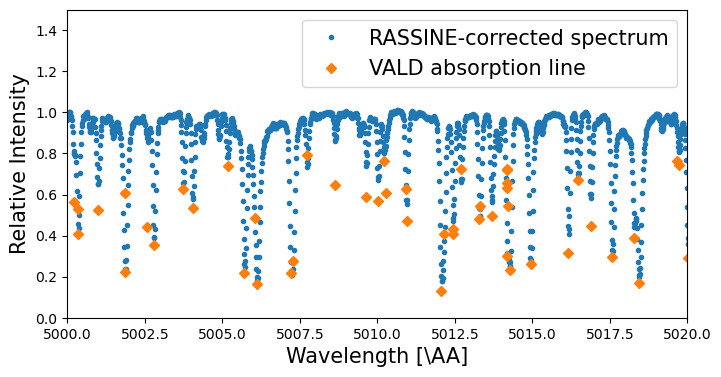

In [14]:
if output_intermediate_results:
    sp.inspect_data(0,an.alldata["spectrum"][0]+1,an.alldata["wavelengths"][0],5000,20)

### Get tapas telluric information

In [15]:
compute_tellurics = True

if os.path.exists(f'{mmlsd_dir}/tellurics/tellurics{star}.pkl'):
    with open(f'{mmlsd_dir}/tellurics/tellurics{star}.pkl',"rb") as f:
        an.tapas_tellurics = pickle.load(f)
        
    if len(iis) == len(an.tapas_tellurics.keys()):
        compute_tellurics = False
        if output_intermediate_results:
            print(f"loaded tellurics from {mmlsd_dir}/tellurics/tellurics"+star+".pkl")
    else:
        compute_tellurics = True
        

if compute_tellurics:
    print("produce tellurics")
    
    transmittance_file = None
    an.get_tapas_transmittance(pipname , transmittance_file, info_file)
    print("save tellurics in ",f'{mmlsd_dir}/tellurics/tellurics{star}.pkl')
    with open(f'{mmlsd_dir}/tellurics/tellurics{star}.pkl',"wb") as f:
        pickle.dump(an.tapas_tellurics,f)

loaded tellurics from ../MM-LSD/tellurics/telluricsSun.pkl


### Set preliminary velocity grid


In [16]:
#set velocity grid

#roughly centre velocity grid around the rv of the star of the first measurement. add +- dvel km/s
dvel = 20
vel_inital = np.arange(systemrv-dvel, systemrv+dvel, vStep)

#set upper limit to number of absorption lines of depth min_depth_required within a region (other regions excluded)
an.alldata["vel_inital"] = vel_inital

### FIRST RUN OF LSD (TO GET FWHM OF SPECTRA, FIRST COMMON PROFILE, AND TO CHECK DEVIATION OF SPECTRA FROM CONVOLUTION MODEL))

In [17]:
#choose test spectrum for the first LSD run
test_ii = 0

an.test_ii = test_ii

#get fluxes, wavelengths, and weights for first spectrum
an.prep_spec(iis[test_ii],an.alldata,erroption)

#choose echelle orders to run code on (all here)
testorders = np.arange(nr_of_orders)

#get rough common profile (equal weight for each order). this is only used to get an idea about the common profile shape.
zlast = np.zeros((len(vel_inital))) 
model_h = np.zeros((nr_of_orders,nr_of_pixels))
count = 0

for order in testorders:
    #output = an.workernorm(order,vel_inital)
    output = an.worker(order,vel_inital)

    if not np.isnan(output[0]).any():
        model_h[order,:] = output[1]
        zlast += output[0]
        count +=1
zlast/=count

an.model_h = model_h
an.div = np.abs(model_h - an.spectrum)

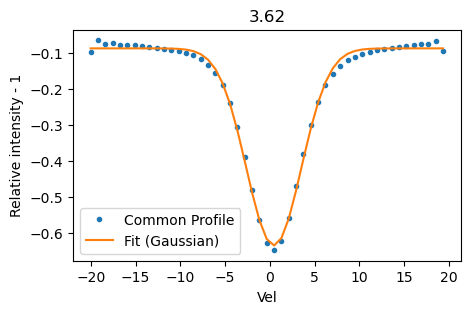

In [18]:
#first common profile

#fit gaussian to common profile and extraxt hwhm
popt, pcov = curve_fit(Gaussian, vel_inital, zlast, [-1, systemrv, 3, 0])
fit = Gaussian(vel_inital,*popt) 

vel_hwhm = np.abs(popt[2])*np.sqrt(np.log(2.)*2.)

if output_intermediate_results:
    plt.figure(figsize=(5,3))
    plt.plot(vel_inital,zlast,".",label="Common Profile")
    plt.plot(vel_inital,fit,label="Fit (Gaussian)")
    
    plt.xlabel("Vel")
    plt.ylabel("Relative intensity - 1")

    plt.title("common profile")

    plt.title(np.round(vel_hwhm,2))
    plt.legend()

#estimate typical half-width of an absorption line as 5 times the hwhm
#will be multiplied by wvl when used

an.alldata["initial_v_halfwidth"]=vel_hwhm

In [19]:
velsigma = np.abs(popt[2])

### Set velocity grid

In [20]:
#new velocity grid based on first run.

dvel = np.round(vel_hwhm)*velgridwidth
vel = np.arange(systemrv-dvel, systemrv+dvel, vStep)

#set upper limit to number of absorption lines of depth min_depth_required within a region (other regions excluded)
an.alldata["vel"] = vel

#how much should we exclude near data points with high model-spectrum deviation?
an.alldata["absline_halfwidth_include"] = (vel.max()-vel.min()+1.)/2./ckm

### EXCLUDE SPECTRAL REGIONS WITH HIGH MODEL-SPECTRUM DEVIATION

In [21]:
an.get_wide_lines()
an.get_q_map(info_file)
#get telluric map.
an.get_t_map()

### RUN LSD ON ALL SPECTRA WITH QUALITY/TELLURIC MAP

In [22]:
#multiprocessing
num_processors = 4

#on which orders to run
testorders = np.arange(nr_of_orders)

#save results here
LSD_results = {}

vel = an.alldata["vel"]

In [23]:
for ii in iis:
    LSD_results[ii] = {}
    weights,spectrum,wavelengths = prep_spec3(an.alldata,ii,an.tapas_tellurics,erroption=erroption,usetapas=usetapas)
    incl_map = np.zeros((np.shape(spectrum)))

    selection = (weights>0)

    incl_map[selection] = 1
    LSD_results[ii]["incl_map"] = incl_map

In [24]:
#define weight matrix to compute order weights (to combine common profiles to master common profile)

wmat = np.ones((len(iis),nr_of_orders))

for count1,ii in enumerate(iis):
    if erroption == 0:
        pre_weights = 1./(an.alldata["err"][ii]**2)
    if erroption ==1:
        pre_weights = 1./(an.alldata["err_envelope"][ii]**2)
    if erroption ==2:
        err = np.transpose(np.tile(np.median(an.alldata["err"][ii],axis=1),(np.shape(an.alldata["err"][0])[1],1)))
        pre_weights = 1./(err**2)

    #pre_weights*=1./corrfact**2
    pre_weights[LSD_results[ii]["incl_map"]==0]=0

    for count,order in enumerate(testorders):
        wmat[count1,order] = np.nanmean(pre_weights[order,:])

an.alldata["order_weight"] = np.mean(wmat,axis=0)

### Master spectrum

In [25]:
def getmodelxy(iisuse,stellarrestframe):
    modelx = []
    modely = []
    modelweights = []
    
    for ii in iisuse:

        #get weights, spectrum, wavelengths after excluding some data according to parameters.
        weights,spectrum,wavelengths = prep_spec3(an.alldata,ii,an.tapas_tellurics,erroption=erroption,usetapas=usetapas)
        if stellarrestframe:
            wavelengths *= 1.-drs_norm[ii]/(ckm*1000.)
            
        modelx.append(wavelengths)
        modely.append(spectrum)
        #modelweights.append(weights)

    modelx = np.ravel(modelx)
    modely = np.ravel(modely)
    
    #modelweights = np.ravel(modelweights)

    sort = np.argsort(modelx)

    modelx = modelx[sort]
    modely = modely[sort]
    #modelweights = modelweights[sort]

    #remove extreme outliers
    modelx = modelx[modely<0.3]
    #modelweights = modelweights[modely<0.3]
    modely = modely[modely<0.3]
    
    #using weights for spline leads to bad models (as too much weight on centre of absorption lines)
    return modelx,modely



iisuse = np.asarray(iis)[::3][:100]

if len(iisuse)<50:
    print("less than 50 spectra")
    iisuse = np.asarray(iis)[:100]

modelx,modely = getmodelxy(iisuse,stellarrestframe=stellarrestframe)
spl0 = LSQUnivariateSpline(x=modelx, y=modely, t=modelx[len(iisuse)//2:-10:len(iisuse)])

less than 50 spectra


In [26]:
chisqii = np.zeros((len(iisuse)))

for ctt,ii in enumerate(iisuse):
    weights,spectrum,wavelengths = prep_spec3(an.alldata,ii,an.tapas_tellurics,erroption=erroption,usetapas=usetapas)
    #print(np.sum((spl1(wavelengths)-spectrum)**2*weights))
    #chisqii[ii] = np.sum((spl0(wavelengths)-spectrum)**2*weights)
    chisqii[ctt] = np.sum((spl0(wavelengths)-spectrum)**2*weights)/np.sum(weights)

Text(0.5, 1.0, 'Included spectra for master spectrum')

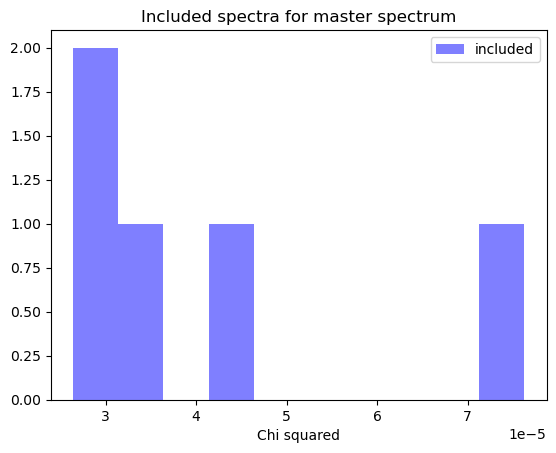

In [27]:
selected = scipy.stats.sigmaclip(chisqii, low=100.0, high=3.0).clipped

iisuse_selection = np.in1d(chisqii,selected)

plt.figure()
plt.hist(chisqii[iisuse_selection],bins=10,color="blue",alpha=0.5,label="included")
if sum(iisuse_selection)<len(iisuse_selection)-1:
    plt.hist(chisqii[~iisuse_selection],bins=10,color="red",alpha=0.5,label="excluded")

plt.legend()
plt.xlabel("Chi squared")
plt.title("Included spectra for master spectrum")

In [28]:
#select good spectra for new spline

iisusenew = iisuse[iisuse_selection]
#iisusenew =iisuse
modelx,modely = getmodelxy(iisusenew,stellarrestframe=stellarrestframe)

spl1 = LSQUnivariateSpline(x=modelx, y=modely, t=modelx[len(iisuse)//2:-10:len(iisuse)])

#which spectra have been excluded?

iisexcluded = iisuse[~iisuse_selection]
print(f"excluded spectra: {iisexcluded}")

excluded spectra: []


In [29]:
iis = np.asarray(iis)

In [30]:
#only small differences if many (>40 spectra are included), check impact

oldbetter = 0
fromprevset = 0

for ii in iisuse:
    weights,spectrum,wavelengths = prep_spec3(an.alldata,ii,an.tapas_tellurics,erroption=erroption,usetapas=usetapas)

    if np.sum((spl1(wavelengths)-spectrum)**2*weights)-np.sum((spl0(wavelengths)-spectrum)**2*weights)>0:
        oldbetter+=1
        if ii in iisexcluded:
            fromprevset+=1
print(f"Cleaning improved fit for {len(iisuse)-(oldbetter-fromprevset)} out of {len(iisuse)-fromprevset} good quality spectra.")

Cleaning improved fit for 5 out of 5 good quality spectra.


### Run B extraction

In [31]:
def worker3c(orders,mn,mx,weights,spectrum,wavelengths,vlambda,vdepth,vel,alpha=1,B=1):
    """
    For given order: perform LSD and extract the common profile, common profile uncertainties. Compute convolution model 
    Parameters
    ----------
    order : int
        First array: periods [d]
    weights : array orders x pixels
        Weights of the individual fluxes
    spectrum : array orders x pixels
        Fluxes
    wavelengths : array orders x pixels
        Wavelength corresponding to the fluxes
    vlambda : array
        Central wavelength of absorption lines (VALD3)
    vdepth : array
        Depth of absorption lines (VALD3)
    vel : array
        Velocity grid to run LSD on (velocity grid for common profile)
    
    Output:
    ----------
    Z : array
        common profile
    Zerr : array
        uncertainty estimates of common profile
    M.dot(Z) : array
        convolution model
    selection : array
        indices of included pixels
    """    
    weights=weights[orders]
    spectrum=spectrum[orders]
    wavelengths=wavelengths[orders]
    
    #Get data of given order
    #Only include data with weight > 0
    selection = np.where(weights>0)
    
    spectrum_o = spectrum[selection].ravel()
    wavelengths_o = wavelengths[selection].ravel()
    weights_o = weights[selection].ravel()           

        

    wo = (np.abs(sp.mean_lande)>-0.5)


    vl = np.hstack(([vlambda[wo],vlambda[~wo]]))

    #proportionality factor for zeeman residuals
    multfact = vdepth[wo]*(1.4*sp.mean_lande[wo]*vlambda[wo]/10000/(3.*10**5))**2
    

    vd = np.hstack(([multfact,np.zeros((len(vlambda[~wo])))]))

    
    vdorig = np.hstack(([vdepth[wo],np.zeros((len(vlambda[~wo])))]))
    #vdorig = np.hstack(([origfact,vdepth[~wo]]))

    sort = np.argsort(vl)
    
    vl = vl[sort]
    vd = vd[sort]
    #depths for rv extraction
    vdorig = vdorig[sort]
        
    #CREATE CONVOLUTION MATRIX
    #-----------------------------------------------------
    

    #zeeman convolution matrix
    value, row, column = an.cvmt(wavelengths_o, vel, vl,vd)
    M = csc_matrix((value,(row,column)), shape=(len(wavelengths_o), len(vel)))

    return M,weights_o,spectrum_o,wavelengths_o,value, row, column


In [32]:
#only shape, no amplitude = B*B*alpha =ampl

def genestshape(vel,v0,sigma,ckm,ampl):
    #you can also use this. difference is negligible.
    #return 2.*ampl*((0.5*ckm**2/sigma**2)-(1/2.*ckm**2/sigma**2)*((vel-v0)**2/sigma**2))*np.exp(-(vel-v0)**2/2/sigma**2)

    return 2.*ampl*((0.5*ckm**2/sigma**2)+3./8-(1.+1/2.*ckm**2/sigma**2)*((vel-v0)**2/sigma**2))*np.exp(-(vel-v0)**2/2/sigma**2)

def gs(ampl,sigma,v0):
    return genestshape(vel,v0,sigma,ckm,ampl)

### Compare approximations with numerical gauss-gauss shapes

### Run B extraction on spectra

In [33]:
assert t.max()<100000, "check this"

In [34]:
#define weight matrix to compute order weights (to combine common profiles to master common profile)

wmat = np.ones((len(iis),nr_of_orders))

for count1,ii in enumerate(iis):
    if erroption == 0:
        pre_weights = 1./(an.alldata["err"][ii]**2)

    pre_weights[LSD_results[ii]["incl_map"]==0]=0

    for count,order in enumerate(testorders):
        wmat[count1,order] = np.nanmean(pre_weights[order,:])

an.alldata["order_weight"] = np.mean(wmat,axis=0)

In [35]:
orders = np.arange(69)
indices_to_run = np.asarray(iis)

mxs = [maxdepthparam]
mns = [mindepthparam]

mn = mns[0]
mx = mxs[0]

#empty containers
ests_fit_b = np.zeros((len(indices_to_run),len(orders)*len(mxs)*len(mns)))


thresh = 0
for count,iit in enumerate(indices_to_run):
    #sge = ((info_file["ccf_fwhm"].values/2.355))[iit]
    #sge = np.mean(((info_file["ccf_fwhm"].values/2.355))[iisusenew])
    sge = velsigma

    cfactor = (lsd_norm[iit]/1000./ckm+1)
    
    if iit//50 == iit/50:
        print(iit,"/",len(indices_to_run))

    weights,spectrum,wavelengths = prep_spec3(an.alldata,iit,an.tapas_tellurics,erroption=erroption,usetapas=usetapas)
    
    for order_ct,order in enumerate(orders):
        M,weights_o,spectrum_o,wavelengths_o,value, row, column = worker3c([order],
                                          mn = mn,
                                          mx = mx,
                                          weights=weights,
                                          spectrum=spectrum,
                                          wavelengths=wavelengths,
                                          vlambda=sp.VALDlambdas,
                                          vdepth=sp.VALDdepths,
                                          vel=vel,
                                          alpha=1,
                                          B=1)

        
        if stellarrestframe:
            wavelengths_o *= 1.-drs_norm[iit]/(ckm*1000.)


        if True:
            #both are defined as spec/mean(spec)-1. thus continuum at 0, line cores below 0. definition on overleaf is exp(...), so positive
            #thus minus signs here

            dev = -spl1(wavelengths_o/cfactor) + spectrum_o

            thresh = np.std(dev.ravel())*10
            worem = np.abs(dev.ravel())>thresh
            weights_o[worem] = 0

        if True:
            #USE THIS
            
            def obj4(params): 
                return (dev.ravel()-M.dot(gs(params[0],sge,vzr+lsd_norm[iit]/1000.)))*np.sqrt(weights_o)
             
            
            res4 = least_squares(obj4,x0=[10**-3]).x
            ests_fit_b[count,order_ct] = res4[0]



0 / 5


### function to compute B proxy

In [36]:
def getproxy(ests,orders_use):
    



    est2_1 = ests[:,orders_use]
    wmatuse = wmat[:,orders_use]
    
    wm = (wmatuse.transpose()/np.sum(wmatuse,axis=1)).transpose()
    est2_1_out = (np.sum(est2_1*wm[indices_to_run,:],axis=1))

    
 
    return est2_1_out

### Get B proxy 

In [37]:
proxy = getproxy(ests_fit_b,orders)


In [38]:
if star[:3]=="Sun" and len(t_bjd)>20:
    #calculate viewing angle effect on proxy (just necessary for solar data)
    #difficult to do with few data points -> len(t_bjd)>20
    
    fwhm_corr = vae_fct(t_bjd,*popt_vae)
    
    periods = np.arange(100,365)
    freq = 1./periods
    
    def scal(scaling_factor):
        power2 = LombScargle(t, proxy-fwhm_corr*scaling_factor).power(freq)
        return power2[periods==182]
    
    res = minimize(scal, x0=[0])
       
    vae_corr_scaled = fwhm_corr*res.x
else:
    vae_corr_scaled = np.zeros((len(drs_norm)))[indices_to_run]
    hc =np.zeros((len(drs_norm)))
    
proxy_corrected = proxy - vae_corr_scaled

In [39]:
print("If solar data: Did you apply the correction to the heliocentric restframe and apply the Sun-Earth viewing angle correction?\n")

If solar data: Did you apply the correction to the heliocentric restframe and apply the Sun-Earth viewing angle correction?



Text(0, 0.5, 'B proxy')

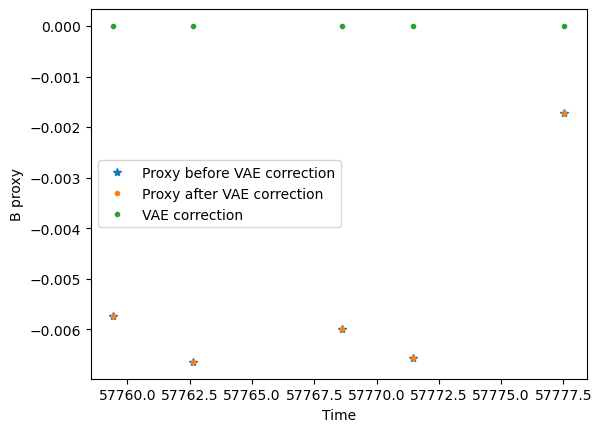

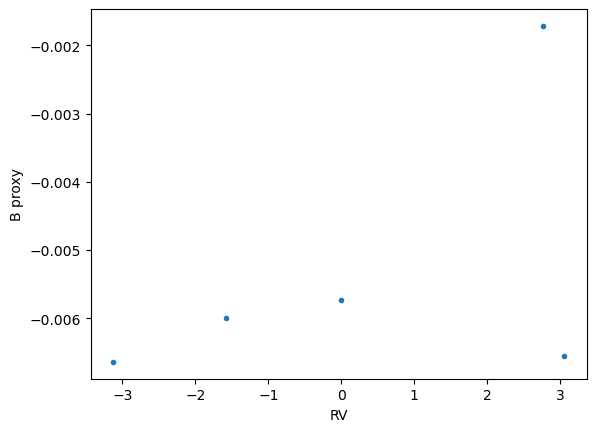

In [40]:
plt.figure()
plt.plot(t,proxy,"*",label="Proxy before VAE correction")
plt.plot(t,proxy_corrected,".",label="Proxy after VAE correction")
plt.plot(t,vae_corr_scaled,".",label="VAE correction")
plt.legend()
plt.xlabel("Time")
plt.ylabel("B proxy")

plt.figure()
plt.plot(drs_norm-hc,proxy_corrected,".")
plt.xlabel("RV")
plt.ylabel("B proxy")


In [41]:
print("pearson correlation proxy, RV heliocentric:\n")
print("LSD",scipy.stats.pearsonr(proxy_corrected,(lsd_norm-hc)[indices_to_run])[0].round(3))
print("CCF",scipy.stats.pearsonr(proxy_corrected,(drs_norm-hc)[indices_to_run])[0].round(3))


print("\n\nspearman correlation proxy, RV heliocentric:\n")
print("LSD",scipy.stats.spearmanr(proxy_corrected,(lsd_norm-hc)[indices_to_run]).correlation.round(3))
print("CCF",scipy.stats.spearmanr(proxy_corrected,(drs_norm-hc)[indices_to_run]).correlation.round(3))

pearson correlation proxy, RV heliocentric:

LSD 0.727
CCF 0.514


spearman correlation proxy, RV heliocentric:

LSD 0.7
CCF 0.4


In [42]:
df_out = pd.DataFrame()
df_out["BJD"] = t_bjd
df_out["MJD"] = t
df_out["proxy"] = proxy
df_out["proxy_corrected"] = proxy_corrected
df_out["heliocentric_correction"] = hc
df_out["viewing_angle_correction"] = vae_corr_scaled
df_out["LSD RVs"] = lsd_norm
df_out["DRS RVs"] = drs_norm
df_out.to_csv("results.csv")